<a href="https://colab.research.google.com/github/weisds/DeepLearning-Marketing_Campaign/blob/main/DeepLearning_Marketing_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import libraries
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import label_binarize

from sklearn.preprocessing import StandardScaler

## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Objective
The objective in this study is to create a binary classifition model with neural nets to predict if the customer will accept the offer in a marketing campaign or not. Also to understand what determines this end result by looking at the feature improtance of the model.

#Data
This dataset is from Kaggle called [Marketing Campaign](https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign). This data dataset contains 29 columns and 2240 rows, covering information around time the customer was with the company, average spending in different product, number web visits, etc. The target variable is Response, a binary column indicating whether the customer accepted the offer or not.

In [ ]:
#@title EDA and cleaning
#@markdown <ol><li>Find and replace nulls</li><li>seperate categorical and numeric data</li> <li>One-hot and lable encode data</li> <li>finding and cleaning outliers</li</ol> 
#@markdown 
df = pd.read_csv('/content/drive/MyDrive/Coursera/Dataset/marketing_campaign.csv', sep=";")

In [ ]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [ ]:
#replace null with mean
df['Income'] = df['Income'].fillna(value=df['Income'].mean())

In [ ]:
#check the different types of data, planning for transforming data
df.dtypes.value_counts()

int64      25
object      3
float64     1
dtype: int64

In [ ]:
#set X and y
y = df.Response
X = df.drop(['Response','ID'], axis=1)

In [ ]:
#let split the data for more targeted handling
txt_cols = [cname for cname in X.columns if df[cname].dtype == "object"]

# Select numerical columns
num_cols = [cname for cname in X.columns if df[cname].dtype in ['int64', 'float64']]

In [ ]:
#have an overview on the txt unique data, to determine onehot, ordinal, or type transfromation 
txt_uniques = pd.DataFrame([[i, len(X[i].unique()), X[i].unique()] for i in X[txt_cols]], columns=['Variable', 'number of Unique Values', 'Unique Values']).set_index('Variable')
txt_uniques

,number of Unique Values,Unique Values
Variable,,
Education,5,"[Graduation, PhD, Master, Basic, 2n Cycle]"
Marital_Status,8,"[Single, Together, Married, Divorced, Widow, A..."
Dt_Customer,663,"[2012-09-04, 2014-03-08, 2013-08-21, 2014-02-1..."


In [ ]:
#ordinal data transformation dependng on the education level
from sklearn.preprocessing import OrdinalEncoder
oen = OrdinalEncoder(categories=[['Basic','Graduation','2n Cycle', 'Master', 'PhD']])
X['Education'] = oen.fit_transform(X[['Education']])

In [ ]:
#onehot transfromation for nominal data
from sklearn.preprocessing import OneHotEncoder #OneHot Encoder
OH_en = OneHotEncoder(handle_unknown='ignore', sparse=False)
imp_txt_cols = OH_en.fit_transform(df[['Marital_Status']])
imp_txt_cols = pd.DataFrame(imp_txt_cols)
#now we align the index and col names
imp_txt_cols.index = df[['Marital_Status']].index
imp_txt_cols.columns = OH_en.get_feature_names(['Marital_Status'])
X=X.drop(['Marital_Status'], axis=1).join(imp_txt_cols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#creating new feature - Tenure, drop the date column - Dt_Customer as we are not using it in later analysis
maxDate = pd.to_datetime(X.Dt_Customer).max()
tenure = maxDate - pd.to_datetime(X.Dt_Customer)
X['Tenure'] = tenure.dt.days
X = X.drop(['Dt_Customer'], axis=1)

In [ ]:
#get the continuous values
num_uniques = pd.DataFrame([[i, len(X[i].unique()), X[i].unique()] for i in X[num_cols]], columns=['Variable', 'number of Unique Values', 'Unique Values']).set_index('Variable')
num_variables_with_ol = list(num_uniques[num_uniques['number of Unique Values'] > 10].index)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e9e46cbd0>,
      dtype=object)

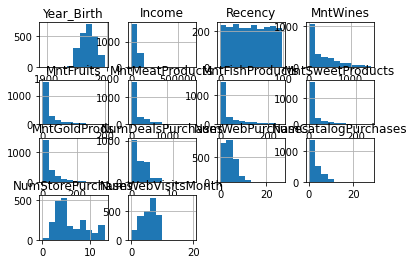

In [ ]:
#@title Identifying columns with outliers
X[num_variables_with_ol].hist()

In [ ]:
#@title Romoving features with no outliers
no_outliers = ['Recency','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases']

for item in no_outliers:
  num_variables_with_ol.remove(item)

In [ ]:
#@title Using the 1.5 * IQR approach to create upper and lower fance to extract outliers
def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  IQR = Q3 - Q1

  lower_b = Q1 - 1.5 * IQR
  uppper_b = Q3 + 1.5 * IQR
  ls = df.index[(df[ft] < lower_b) | (df[ft] > uppper_b)]
  return ls

In [ ]:
#creating and filling in the outlier list
from pandas._libs import index
index_list = []
for feature in num_variables_with_ol:
  index_list.extend(outliers(X, feature))

In [ ]:
#droping the outliers
index_list = sorted(set(index_list))
X = X.drop(index_list)
y = y.drop(index_list)

In [ ]:
#making sure X and y have the same length
X.shape[0] == y.shape[0]

True

#   Modeling and Conclusion
In this section, three deep learning variations were attempted. The objective was to see which neural network variation works best by comparing the accuracy score. We tested the outcomes against the target feature to evaluate models.  We tested neural network with one layer sigmoid, two layers sigmoid, and two layers relu. Following the modeling analysis, the results showed that the two layers sigmoid network structure yeilds the best result, with an accuracy score of 88.9%, whereas the other two models scored almost the same at around 87%.  As such, based on this study, we recommand using the two layers sigmoid structure to build out the neural network predictor. However, in previous study, this data was attempted with RandomForestClassifier and had an accuracy score of 97%. Therefore, we recommand against using deep learning techniques for this data if other options were avaliable. Lastly, we ran a feature importance analysis with the best scored model. The result shows that longer a customer has not purchased from the website is likely will accept the offer. This result also impacted by how long the customer is with the company and if the customer accepted offers in campaign number 3.

In [ ]:
#disproprotional outcome so using StratifiedShuffleSplit to get train and test set
sss = StratifiedShuffleSplit(n_splits=1, random_state=666, test_size=0.3)
train_i, test_i = next(sss.split(X, y))
X_train = X.iloc[train_i]
y_train = y.iloc[train_i]
X_test = X.iloc[test_i]
y_test = y.iloc[test_i]


In [ ]:
## First let's normalize the data

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [ ]:
# Define the Model 

model_sm_1 = Sequential()
model_sm_1.add(Dense(16,input_shape = (len(X.columns),),activation = 'sigmoid'))
model_sm_1.add(Dense(1,activation='sigmoid'))

In [ ]:
# Fit(Train) the Model

model_sm_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_sm_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)

In [ ]:
#default outputs probability, need to convert it to the two classes
y_pred_sm_1= (model_sm_1.predict(X_test_norm) > 0.5).astype('int32')

In [ ]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_sm_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_sm_1)))

accuracy is 0.874
roc-auc is 0.572


In [ ]:
#attempt with an additional layer
model_sm_2 = Sequential()
model_sm_2.add(Dense(16,input_shape = (len(X.columns),),activation = 'sigmoid'))
model_sm_2.add(Dense(16,activation = 'sigmoid'))
model_sm_2.add(Dense(1,activation='sigmoid'))

model_sm_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_sm_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

In [ ]:
y_pred_sm_2= (model_sm_2.predict(X_test_norm) > 0.5).astype('int32')

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_sm_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_sm_2)))

accuracy is 0.889
roc-auc is 0.699


In [ ]:
#attempt relu as the activation function
model_rl_2 = Sequential()
model_rl_2.add(Dense(16,input_shape = (len(X.columns),),activation = 'relu'))
model_rl_2.add(Dense(16,activation = 'relu'))
model_rl_2.add(Dense(1,activation='relu'))

model_rl_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_rl_2 = model_rl_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

In [ ]:
y_pred_rl_2= (model_rl_2.predict(X_test_norm) > 0.5).astype('int32')

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_rl_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_rl_2)))

accuracy is 0.877
roc-auc is 0.729


In [ ]:
import shap

explainer = shap.DeepExplainer(model_sm_2, X_train_norm)
shap_values = explainer.shap_values(X_test_norm)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


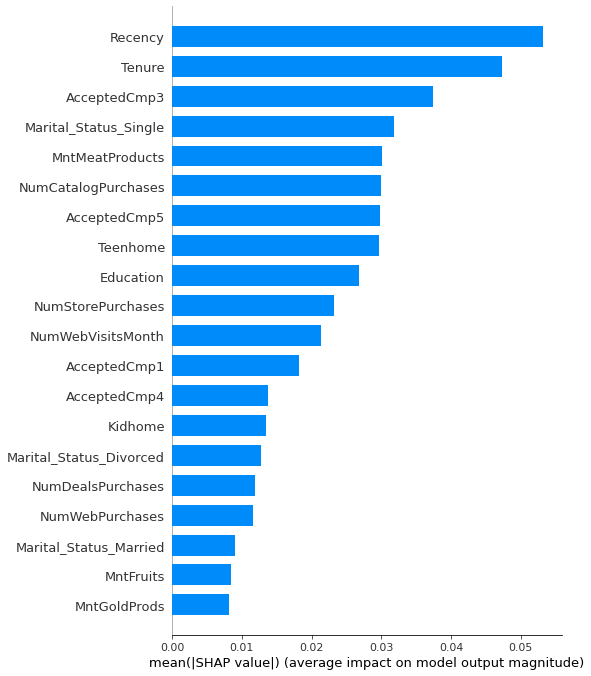

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X.columns)